In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Translation files

Importing fastai.text

In [2]:
from fastai.text import *

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

In [3]:
#!ls data/translate/

Each line contains a pair of sentences both in french and in english separated by a tabulation (TSV : Tab Separated Values)

In [3]:
#!head -n 5 data/en-fr.txt
!head -n 5 data/fr-en.txt

Va !	Go.
Cours !	Run!
Courez !	Run!
Ça alors !	Wow!
Au feu !	Fire!


The data should be found in the file en-fr.txt in the folder data/  
data/tmp will contain temporary files

In [4]:
PATH = Path('data')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
#fname = PATH/'en-fr.txt'
fname = PATH/'fr-en.txt'

Reading the file with utf-8 encoding

In [99]:
lines = list(open(fname, encoding='utf-8'))
#lines = lines[:50] # the first 50 pairs, comment out this line to train on the whole dataset

In [100]:
len(lines)

149861

In [ ]:
#lines = lines[:100]

In [101]:
lines = np.random.choice(lines, 100)
len(lines)

100

In [102]:
lines[:5]

array(["Vous n'êtes pas invitée.\tYou aren't invited.\n", 'Il sauta une classe.\tHe skipped a year.\n',
       "On ne peut pas faire entendre raison à Tom.\tYou can't reason with Tom.\n",
       "Je ne voulais pas que vous vous sentiez seul.\tI didn't want you to feel you were alone.\n",
       "Ne laisse pas les enfants monopoliser la télévision.\tDon't let the children monopolize the television.\n"],
      dtype='<U637')

Separating english and french sentences

In [110]:
en = []
fr = []
for line in lines:
    #enSentence, frSentence = line.rstrip().split('\t') # .rstrip() to remove the trailing \n in each line
    frSentence, enSentence = line.rstrip().split('\t') # .rstrip() to remove the trailing \n in each line
    en.append(enSentence)
    fr.append(frSentence)

In [111]:
list(zip(en[:5], fr[:5]))

[("You aren't invited.", "Vous n'êtes pas invitée."),
 ('He skipped a year.', 'Il sauta une classe.'),
 ("You can't reason with Tom.", 'On ne peut pas faire entendre raison à Tom.'),
 ("I didn't want you to feel you were alone.",
  'Je ne voulais pas que vous vous sentiez seul.'),
 ("Don't let the children monopolize the television.",
  'Ne laisse pas les enfants monopoliser la télévision.')]

Saving the sentences as pickle files (.pkl)

In [112]:
pickle.dump(en, (PATH/'en.pkl').open('wb'))
pickle.dump(fr, (PATH/'fr.pkl').open('wb'))

Loading the sentences, reading them from pickle files  
##### Add some logic before all the previous code, if you find the following files: {en,fr}.pkl, load them directly without doing it all over again

In [113]:
en = pickle.load((PATH/'en.pkl').open('rb'))
fr = pickle.load((PATH/'fr.pkl').open('rb'))

In [114]:
list(zip(en[:5], fr[:5])), len(lines)

([("You aren't invited.", "Vous n'êtes pas invitée."),
  ('He skipped a year.', 'Il sauta une classe.'),
  ("You can't reason with Tom.",
   'On ne peut pas faire entendre raison à Tom.'),
  ("I didn't want you to feel you were alone.",
   'Je ne voulais pas que vous vous sentiez seul.'),
  ("Don't let the children monopolize the television.",
   'Ne laisse pas les enfants monopoliser la télévision.')],
 100)

Tokenizing the english sentences, using fastai and spacy

In [115]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en))

In [116]:
en_tok[:5]

[['you', 'are', "n't", 'invited', '.'],
 ['he', 'skipped', 'a', 'year', '.'],
 ['you', 'ca', "n't", 'reason', 'with', 'tom', '.'],
 ['i', 'did', "n't", 'want', 'you', 'to', 'feel', 'you', 'were', 'alone', '.'],
 ['do',
  "n't",
  'let',
  'the',
  'children',
  'monopolize',
  'the',
  'television',
  '.']]

In [16]:
#!python -m spacy download fr

Tokenizing the french sentences, using fastai and spacy

In [117]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr), 'fr')

In [118]:
fr_tok[:5]

[['vous', "n'", 'êtes', 'pas', 'invitée', '.'],
 ['il', 'sauta', 'une', 'classe', '.'],
 ['on', 'ne', 'peut', 'pas', 'faire', 'entendre', 'raison', 'à', 'tom', '.'],
 ['je', 'ne', 'voulais', 'pas', 'que', 'vous', 'vous', 'sentiez', 'seul', '.'],
 ['ne',
  'laisse',
  'pas',
  'les',
  'enfants',
  'monopoliser',
  'la',
  'télévision',
  '.']]

In [119]:
en_tok[0], fr_tok[0]

(['you', 'are', "n't", 'invited', '.'],
 ['vous', "n'", 'êtes', 'pas', 'invitée', '.'])

In [141]:
#np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

In [142]:
#keep = np.array([len(o)<30 for o in en_tok])

In [143]:
#en_tok = np.array(en_tok)[keep]
#fr_tok = np.array(fr_tok)[keep]

Saving the tokenized sentences as pickle files (.pkl)

In [120]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

Loading the tokenized sentences, reading them from pickle files

In [5]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

The following function will get as arguments the list of tokenized sentences and their language ID  
and returns the sentences converted to IDs, and the mappings ID -> token and token -> ID

In [6]:
def toks2ids(tok,pre):
    """
        Convert tokens to IDs
        tok is the list of tokenized sentences
        pre is the name of the language, example: 'fr', 'en', ...
    """
    freq = Counter(p for o in tok for p in o) # puts all tokens in Counter(.)
    
    # for a token, returns its index, int-to-string
    itos = [o for o,c in freq.most_common(40000)] # 40K most common tokens, returns tuples (token, frequency)
    itos.insert(0, '_bos_') # begining of sentence
    itos.insert(1, '_pad_') # padding
    itos.insert(2, '_eos_') # end of sentence
    itos.insert(3, '_unk_') # unknown
    # itos = [_bos_, _pad_, _eos_, _unk_, token1, token2, ...]
    
    # reverse mapping: string-to-int
    # returns 3 '_unk_' if the token isn't found
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    # stoi = {_bos_:0, _pad_:1, _eos_:2, _unk_:3, token1:4, token2:5, ...}
    
    # converts the tokenized sentences: replaces the token by its id using stoi
    # notice that we've appended 2 (_eos_) at the end of each sentence
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    
    # saving the ids to a .npy file
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    
    # saving the itos mapping to a .pkl file
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    
    return ids, itos, stoi

In [7]:
en_ids, en_itos, en_stoi = toks2ids(en_tok,'en')
fr_ids, fr_itos, fr_stoi = toks2ids(fr_tok,'fr')

The following function will load the mappings (saved from the previous function)  
and returns the sentences converted to IDs, and the mappings ID -> token and token -> ID

In [8]:
def load_ids(pre):
    """
        load saved IDs
        pre is the name of the language, example: 'fr', 'en', ...
    """
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids, itos, stoi

In [9]:
en_ids, en_itos, en_stoi = load_ids('en')
fr_ids, fr_itos, fr_stoi = load_ids('fr')

The following is how to use the ID -> token mapping to reconstruct the original tokenized sentence

In [10]:
[fr_itos[o] for o in fr_ids[0]], len(fr_itos)

(['vous', "n'", 'êtes', 'pas', 'invitée', '.', '_eos_'], 368)

In [11]:
[en_itos[o] for o in en_ids[0]], len(en_itos)

(['you', 'are', "n't", 'invited', '.', '_eos_'], 304)

In [12]:
en_ids[:5]

array([list([5, 14, 9, 95, 4, 2]), list([15, 96, 11, 97, 4, 2]), list([5, 98, 9, 99, 30, 17, 4, 2]),
       list([6, 18, 9, 20, 5, 7, 100, 5, 52, 101, 4, 2]), list([12, 9, 53, 8, 102, 103, 8, 104, 4, 2])],
      dtype=object)

## Word vectors

fasttext word vectors available from https://fasttext.cc/docs/en/english-vectors.html

In [9]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [13]:
import fastText as ft

To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [14]:
!ls data/

embeddings  en.pkl	fr-en.txt  fr_tok.pkl  tmp	    wiki.fr.pkl
en-fr.txt   en_tok.pkl	fr.pkl	   models      wiki.en.pkl


Loading the embeddings (word vectors), the embeddings used here are trained on the text corpus of the bible  
replace them with other embeddings (wikitext for example) to get better results

In [15]:
#en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))
en_vecs = ft.load_model(str((PATH/'embeddings/en.bin')))

In [16]:
#fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))
fr_vecs = ft.load_model(str((PATH/'embeddings/fr.bin')))

Even, if the word isn't found in the embedding Fasttext, find and returns its unique embedding vector

In [17]:
emb = en_vecs.get_word_vector('word')
emb, len(emb)

(array([-0.42811,  0.00472, -0.55592,  0.23108,  0.25022, -0.24158, -0.45753, -0.35123, -0.33665, -0.10807,
        -0.08436, -0.25136, -0.56695, -0.84764, -0.1322 ,  0.14316, -0.48988, -0.327  , -0.20238,  0.10418,
         0.64037, -0.52406,  0.37063,  0.08053, -0.22075, -0.3133 , -0.16693,  0.27541, -0.83423,  0.72061,
         0.26193, -0.26927,  0.33067, -0.29437, -0.18973,  0.24391,  0.21215, -0.18755,  0.08848, -0.49965,
         0.66024,  0.34113,  0.05566, -0.03431, -0.08241,  0.18887,  0.10322,  0.30522,  1.01105,  0.70856,
        -0.02141, -0.09663, -0.51842,  0.40998,  0.36047,  0.09259,  0.12745,  0.1713 ,  0.67702,  0.51115,
         0.59954,  0.11556,  0.1054 , -0.3921 , -0.13521,  0.14449, -0.54714, -0.13172, -0.06877,  0.21863,
        -0.00522,  0.24992, -0.22379, -0.1001 ,  0.02345,  0.55127,  0.0052 , -0.47208,  0.02044, -0.11235,
        -0.61071,  0.62704, -0.20642, -0.0206 ,  0.05281, -0.07086, -0.25795, -0.68857,  0.2554 , -0.37531,
        -0.41069,  0.25751, 

In [18]:
emb = fr_vecs.get_word_vector('mot')
emb, len(emb)

(array([-0.07974,  0.08461,  0.35847,  0.18693,  0.0896 ,  0.41236,  0.03115,  0.32625,  0.28907,  0.14129,
        -0.33977, -0.14277,  0.09088,  0.03029, -0.27774,  0.04753, -0.09452,  0.27132, -0.22255,  0.38899,
        -0.35074, -0.20456, -0.2683 ,  0.32908,  0.01609, -0.23642, -0.14939,  0.16693,  0.00914, -0.2081 ,
         0.52242, -0.14854,  0.08188,  0.51043, -0.37571, -0.14249, -0.16533, -0.23474,  0.20654, -0.31629,
        -0.1563 , -0.19745, -0.48685,  0.28842, -0.22111, -0.12055, -0.10207,  0.16942,  0.41112,  0.10763,
        -0.00341,  0.6312 , -0.06367, -0.29418, -0.09617, -0.12286,  0.02321,  0.5479 ,  0.12541,  0.66944,
        -0.04868,  0.71005,  0.36709, -0.00205,  0.29375,  0.15777,  0.08099,  0.0686 ,  0.15842,  0.1739 ,
        -0.32733,  0.24166, -0.19596,  0.30417, -0.26513, -0.22868, -0.31623, -0.30047, -0.15973, -0.61035,
         0.49594, -0.15864,  0.234  ,  0.58409,  0.22567,  0.04142, -0.24763,  0.18914, -0.05537, -0.62398,
         0.30289, -0.13245, 

A better way than using the following function is to use fr_vecs and en_vecs directly  
Using a dictionary will trigger a KeyError if we want to get the embedding vector of a word which is not found

In [ ]:
#def get_vecs(lang, ft_vecs):
#    """
#        Creates a dictionary of {word: word vector} from the fasttext object ft_vecs
#        and saving it into a pickle file .pkl
#    """
#    # we can get an error if we want to get the word vector of a word which isn't in this dictionary !
#    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
#    
#    # saving the vector in a .pkl file
#    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
#    return vecd

In [ ]:
#en_vecd = get_vecs('en', en_vecs)
#fr_vecd = get_vecs('fr', fr_vecs)

In [ ]:
#en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
#fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [ ]:
#ft_vecs = en_vecs
#ft_words = ft_vecs.get_words(include_freq=True)
#ft_words[0][:5], ft_words[1][:5]

In [ ]:
#ft_word_dict = {k:v for k,v in zip(*ft_words)}
#ft_word_dict

In [ ]:
#ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])
#ft_words

In [ ]:
#len(ft_words)

Using the following functions is a better idea

In [19]:
def getFrWordVector(word):
    return fr_vecs.get_word_vector(word)

In [20]:
def getEnWordVector(word):
    return en_vecs.get_word_vector(word)

In [21]:
dim_en_vec = len(getEnWordVector(','))
dim_fr_vec = len(getFrWordVector(','))
dim_en_vec, dim_fr_vec

(100, 100)

In [22]:
#dim_en_vec = len(en_vecd[','] if ',' in en_vecd.keys() else en_vecs.get_word_vector(','))
#dim_fr_vec = len(fr_vecd[','] if ',' in fr_vecd.keys() else fr_vecs.get_word_vector(','))
#dim_en_vec, dim_fr_vec

In [23]:
#en_vecs_np = np.stack(list(en_vecd.values()))
#en_vecs_np.mean(), en_vecs_np.std()

We need to know the mean and the variance of our word vectors  
we can use the following function to do that

In [22]:
def getStatistics(fasttextVectors):
    vecd = {w:fasttextVectors.get_word_vector(w) for w in fasttextVectors.get_words()}
    vecs_np = np.stack(list(vecd.values()))
    return vecs_np.mean(), vecs_np.std()

In [23]:
getStatistics(fr_vecs) # (0.027238548, 0.30283847)

(0.027238548, 0.30283847)

In [24]:
getStatistics(en_vecs) # (0.018482028, 0.27999485)

(0.018482028, 0.27999485)

In [25]:
len(fr_vecs.get_words()), len(en_vecs.get_words())

(10653, 8375)

Both sets of vectors have rughly the same statistics, about 0 mean and 0.3 standard deviation.  
If we multiply the vectors by 0.3, we'll get a new set of vectors (normalized) with mean = 0 and standard deviation = 1

## Model data

Truncating the data isn't a good idea at all ! we shouldn't alter the data, we have to use as it is !

In [27]:
#enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
#frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
#enlen_90, frlen_90

In [28]:
#en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
#fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])
#en_ids_tr[:5]

The following class is a generic PyTorch dataset, used to prepare the data to be used by PyTorch and fastai

In [26]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x, self.y = x, y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    #def __getitem__(self, idx): yield A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

Train-Test split: 90% training / 10% testing

In [27]:
# train-test split
#np.random.seed(42)
trn_keep = np.random.rand(len(en_ids)) > 0.1
en_trn, fr_trn = en_ids[trn_keep], fr_ids[trn_keep]
en_val, fr_val = en_ids[~trn_keep], fr_ids[~trn_keep]
len(en_trn),len(en_val)

(86, 14)

Creating the datasets

In [28]:
trn_ds = Seq2SeqDataset(fr_trn, en_trn)
val_ds = Seq2SeqDataset(fr_val, en_val)

#trn_ds = Seq2SeqDataset(en_trn, fr_trn)
#val_ds = Seq2SeqDataset(en_val, fr_val)

Setting the batch size

In [29]:
#bs=125 # batch size
bs=1 # batch size

**SortishSampler** : Returns an iterator that traverses the data in randomly ordered batches that are approximately the same size. (used for training set)  
**SortSampler** : Returns a sorted iterator (used for testing set)  

In [30]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [66]:
??ModelData

**Classifier** → padding in the beginning. Because we want that final token to represent the last word of the movie review.  
**Decoder** → padding at the end. As you will see, it actually is going to work out a bit better to have the padding at the end.

In [67]:
??DataLoader

In [31]:
# we don't have any data augmentation tasks, so we can set num_workers to 1
# we have to transpose the tensors (why ?!!!)
# we use 1 (_pad_) to pad the shortest tensor, so that all the tensors would have the same length
#     a tensor must be rectangular
# we want our padding to be at the end, not at the start, that's why pre_pad is set to False
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)

# why int(bs*1.6) ?!!!
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)

# PATH is used to save temporary files, models, ...
md = ModelData(PATH, trn_dl, val_dl)

In [32]:
trn_ds[0]

[array([ 7, 18, 43,  6, 97,  4,  2]), array([ 5, 14,  9, 95,  4,  2])]

In [33]:
it = iter(trn_dl)

#for i in it:
#    print(i)

print(next(it))

"""
The (1)s are the padding characters _pad_
The (2)s at the end are the end-of-sentence tokens _eos_
[
   45     7    61    46    10   123   125    62    13    20
    8    42     5     4    26     8     4     5    28    56
   16     4     2     2     5    16     2     2     5     6
    4     2    (1)   (1)    2     4    (1)   (1)    2     4
    2    (1)   (1)   (1)   (1)    2    (1)   (1)   (1)    2
[torch.LongTensor of size 5x10]
, 
   23     6    11    10     6    23    10    11     7    24
   22    17    12    16    56    22    12    12    31     5
    4     4     4     4     4     4     4     4     4     2
    2     2     2     2     2     2     2     2     2    (1)
[torch.LongTensor of size 4x10]
]
"""

its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[
 366
   5
  15
 367
  55
   2
[torch.LongTensor of size 6x1]
, 
 302
  94
 303
   4
   2
[torch.LongTensor of size 5x1]
]


[(11, 10), (9, 7), (7, 8), (8, 10), (10, 9)]

## Initial model

In [71]:
?nn.Embedding

The word vectors have a mean around 0 and a variance around 3, that's why we multiplied the vector by 3  
The general rule is : word_vector x variance + mean

In [72]:
#def create_emb(vecs, itos, em_sz):
#    emb = nn.Embedding(len(itos), em_sz, padding_idx=1) # 1: _pad_, dimension: (vocab size x embedding size)
#    wgts = emb.weight.data
#    miss = []
#    for i,w in enumerate(itos):
#        try: wgts[i] = torch.from_numpy(vecs[w]*3)
#        except: miss.append(w)
#    print(len(miss),miss[5:10])
#    return emb

To make a vector standard normal (have a mean of 0 and a standard deviation of 1)  

$$Y = \frac{X-\mu}{\sigma}$$  

$\mu$ is the mean of X, $\sigma$ is its standard deviation.  
We can create a function to do just that ;)

In [34]:
def normalize(vector, mean, standardDeviation):
    """
        This function returns the 'normalized' version of vector
        by subtracting the mean than dividing by the standard deviation
        Hepler function to be used in the function `create_emb`
    """
    return (vector - mean) / standardDeviation

This version uses the fasttext object firectly so no mises ! even if the word doesn't exist in the original embeddings, fasttext will generate its unique embedding vector. I don't want to miss any word ! whatever was its frequency !

In [32]:
# ------ old implementation ------
#def create_emb(fasttextVectors, itos, em_sz, mean=0, standardDeviation=1): # standardDeviation is 0.3 in our example
#    emb = nn.Embedding(len(itos), em_sz, padding_idx=1) # 1: _pad_, dimension: (vocab size x embedding size)
#    wgts = emb.weight.data
#    #miss = []
#    for i,w in enumerate(itos):
#        #assert len(fasttextVectors.get_word_vector(w)) == em_sz
#        #wgts[i] = torch.from_numpy(fasttextVectors.get_word_vector(w)*standardDeviation)
#        wgts[i] = torch.from_numpy(normalize(fasttextVectors.get_word_vector(w), mean, standardDeviation))
#        #try: wgts[i] = torch.from_numpy(fasttextVectors.get_word_vector(w)*standardDeviation)
#        #except: miss.append(w)
#    #print(len(miss))
#    return emb

In [109]:
#create_emb(en_vecs, en_itos, 100, 0.3)

In [35]:
class FasttextVectorsWrapper():
    """
        Adapter for fasttext objects, used to normalize the embedding vectors
    """
    
    def __init__(self, fasttextVectors, mean=0, standardDeviation=1):
        self.fasttextVectors = fasttextVectors
        self.mean = mean
        self.standardDeviation = standardDeviation
    
    def get_word_vector(self, word):
        return normalize(
            self.fasttextVectors.get_word_vector(word),
            self.mean,
            self.standardDeviation)

```python
# getStatistics(fr_vecs) # (0.027238548, 0.30283847)
fr_vecs = FasttextVectorsWrapper(fr_vecs, 0.027238548, 0.30283847)

# getStatistics(en_vecs) # (0.018482028, 0.27999485)
en_vecs = FasttextVectorsWrapper(en_vecs, 0.018482028, 0.27999485)
```

In [36]:
fr_vecs = FasttextVectorsWrapper(fr_vecs, 0.027238548, 0.30283847)
en_vecs = FasttextVectorsWrapper(en_vecs, 0.018482028, 0.27999485)

In [37]:
def create_emb(fasttextVectorsWrapped, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1) # 1: _pad_, dimension: (vocab size x embedding size)
    wgts = emb.weight.data
    for i,w in enumerate(itos):
        wgts[i] = torch.from_numpy(fasttextVectorsWrapped.get_word_vector(w))
    return emb

In [38]:
create_emb(en_vecs, en_itos, 100)

Embedding(304, 100, padding_idx=1)

In [39]:
nh, nl = 256, 2

xxx_enc are encoder's variables, xxx_dec are decoder's variables  
out_xxx is what's going to be at the output of the encoder / decoder

the GRU computations  
$$
        \begin{array}{ll}
        r_t = \mathrm{sigmoid}(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \mathrm{sigmoid}(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)} \\
        \end{array}
$$

In [80]:
?nn.GRU

In [82]:
?torch.stack

In [84]:
# Returns a new tensor with a dimension of size one inserted at the specified position.
?torch.unsqueeze

In [40]:
class Seq2SeqRNN(nn.Module):
    """
    * The embedding layers are used to get the fasttext embedding vector from the token's index in the vocabulary
    (we can also fine tune the embeddings, they will become learnable parameters, and train them end to end)
    * emb_enc: Embeddings for the encoder
    * emb_dec: Embeddings for the decoder
    * we can use LSTMs instead of GRUs
    * The embedding size of pretrained fasttext vectors is 300
    * The embeddings can be learnable: they have the attribute weight which is a Variable containing the attribute
        data which is a Tensor
    * The embeddings are initially random, we go through our vocabulary, if we find the token, we replace the
        random vector by its corresponding fasttext embedding, the random vectors have a standard deviation of1
        but our fasttext vectors have a standard deviation of 0.3, that's why we've multiplied by 3
    """
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        
        # adding dropout prevent overfitting (add visualization of dropout ? in the presentation and report)
        # analogy: died neurons in the brain !
        self.emb_enc_drop = nn.Dropout(0.15)
        
        # the RNN cell (GRU, LSTM)
        # the input to the RNN is the size of the embedding
        # nh is the number of hidden units
        # nl is the number of layers
        # 0.25 dropout inside the RNN
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        
        # transform the hidden output (RNN output) into something to be fed to the decoder
        # this is a simple transformation, so it should be a matrix multiplication without adding a bias
        # this operation is the reverse of the embedding, and the embedding doesn’t have a bias. (jeremy's answer)
        # that's why bias is set to False
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        # sl: sentence length, bs: batch size
        sl, bs = inp.size()
        h = self.initHidden(bs)
        
        # putting the input into the embedding, then through the dropout
        emb = self.emb_enc_drop(self.emb_enc(inp))
        
        # we put the initial hidden state (zeros) and the embedding to the RNN
        # which spits out the final hidden state
        enc_out, h = self.gru_enc(emb, h)
        
        # the final hidden state is passing through the linear layer so that we'll
        # have something in the right size to feed to our decoder
        h = self.out_enc(h)
        
        # input ---> embedding ---> hidden vector (h, which is the same as s in the figure shown in the course)
        # the hidden vector hopefully will learn to contain all the information about what that sentence
        # says and how it says it

        # the previous translated word, first it is NULL (vector of zeros) --> _bos_ token
        # decoder input, initially zeros (the _bos_ beginning of stream token is 0)
        # long because the output should be the indices
        dec_inp = V(torch.zeros(bs).long()) # bs is the batch size
        
        res = []
        
        # self.out_sl is the length of the largest english sentence, because we're translating into english
        # it can't be possibly longer than that (at least in our corpus), it we use it on longer sentences
        # this will fail, we can pass in a bigger value
        # --> why we don't change it to a while loop (while the token isn't _eos_ or _pad_ ?)
        for i in range(self.out_sl):
            
            # the basic idea is the same: we put the input through the embedding
            # adding a unit axis / dimension in the specified position using .unsqueeze(0)
            # this embedding use the target embedding vectors, in our example, the english word vectors
            # because we're translating from french to english: fr --> en
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            
            # then through the RNN
            outp, h = self.gru_dec(emb, h)
            
            # stick the output of the RNN through the dropout then through a linear layer in order to convert
            # that into the correct size for the decoder embedding matrix (to be used in the next iteration
            # to predict the next word)
            outp = self.out(self.out_drop(outp[0]))
            
            # append the result to the results list (list of translated words)
            # it doesn't have a fixed length ;)
            res.append(outp) # we append the probabilities here not the word !
            
            # outp is a tensor whose length is the number of words in our english (target language) vocabulary
            # and it contains the probability for every one of those words that it is that word
            
            # we have to know what word what to feed in to the next timestamp
            
            # outp.data.max(1) looks for the highest probability
            # max(.) in PyTorch returns 2 things, the maximum value and the argmax
            # (the index into the array at which we've found the maximum value)
            # and we need the index, that's why there is a [1] after the max (to get the 2nd element)
            
            # now dec_inp is whatever the highest probability word was
            dec_inp = V(outp.data.max(1)[1]) # contains the word index in our vocabulary
            
            # if it's a 1 (_pad_), that's mean we're done, we reached the end
            # else, we continue
            if (dec_inp==1).all(): break
                
            # we keep looping through either until we get to the largest length of a sentence or until
            # everything in our mini batch is padding

        # at the end, we're going to stack that list up into a single tensor and return it
        # now, we can feed this tensor into a loss function
        return torch.stack(res)
    
    # used to initialize the hidden state vector with zeros
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

* Normally, a RNN works on a whole sequence at a time but we've got a for loop to go through each part of the sequence separately so we have to add a leading unit access to the start `unsqueeze(0)`  
* Predicting what is the $4^{th}$ word of a sentence without knowing the $3^{rd}$ one is hard ! that's why we need to input the last translated (at time $t-1$) word at each time step to predict the next one (at time $t$)
* Let's think about one part of the batch / one token, with start with a 0 / \_bos\_,  we look up that zero in our embedding matrix to find out what's the vector for the beginning of stream token is, we stick a unit axis on the front to say we have a single sequence, we stick this through our RNN, at first, it will get 2 things: the \_bos\_ token and the hidden state which is the output if the encoder and its task now is to figure out what is the $1^{st}$ word.

In [41]:
# suppose we have a batch_size equals to 5, this is how dec_inp would look like at the begining
V(torch.zeros(5).long())

Variable containing:
 0
 0
 0
 0
 0
[torch.LongTensor of size 5]

In [42]:
# adding a unit axis at the begining (notice how the size changed from 5 to 1x5)
V(torch.zeros(5).long()).unsqueeze(0)

Variable containing:
 0  0  0  0  0
[torch.LongTensor of size 1x5]

In [43]:
# for simplicity we'll supose that our vocabulary have 10 words
nextWordProbabilities = torch.rand(1,10)
nextWordProbabilities


 0.9586  0.0265  0.8499  0.9537  0.8167  0.6053  0.2144  0.9046  0.0376  0.5733
[torch.FloatTensor of size 1x10]

In [44]:
nextWordProbabilities.max(1)[1]


 0
[torch.LongTensor of size 1]

In [45]:
x = torch.rand(2,3,4)
x


(0 ,.,.) = 
  0.2579  0.7438  0.0966  0.6420
  0.5827  0.1917  0.7428  0.2305
  0.0241  0.0927  0.6222  0.9577

(1 ,.,.) = 
  0.2562  0.8452  0.4747  0.4619
  0.5867  0.7910  0.7250  0.4064
  0.5269  0.1850  0.0392  0.2084
[torch.FloatTensor of size 2x3x4]

In [46]:
x.max(1)

(
  0.5827  0.7438  0.7428  0.9577
  0.5867  0.8452  0.7250  0.4619
 [torch.FloatTensor of size 2x4], 
  1  0  1  2
  1  0  1  0
 [torch.LongTensor of size 2x4])

## Loss Function
the loss function is categorical cross-entropy loss ( https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/ )  
we've got a list of probabilities for each of our classes, the classes are all the words in our English vocab and we have a target which is the correct class, the correct word at this location.  
* If the generated sequence length is shorter than the sequence length of the target, we need to add some padding. PyTorch padding function requires a tuple of 6 to pad a rank 3 tensor (sequence length, batch size, by number of words in the vocab). Each pair represents padding before and after that dimension.

In [116]:
?F.pad
#    the dimensions that gets padded begins with the last dimension and moves forward.
#    >>> t4d = torch.Tensor(3, 3, 4, 2)
#    >>> p3d = (0, 1, 2, 1, 3, 3) # pad by (0, 1), (2, 1), and (3, 3)
#    >>> out = F.pad(t4d, p3d, "constant", 0)
#    >>> print(out.data.size())
#    torch.Size([3, 9, 7, 3])
#    (3, 3, 4, 2) --> (3, 3 + 3 + 3, 4 + 2 + 1, 2 + 0 + 1) --> (3, 9, 7, 3)

In [45]:
x = torch.rand(2, 3)
x


 0.5208  0.7188  0.1717
 0.6729  0.1863  0.1165
[torch.FloatTensor of size 2x3]

In [46]:
F.pad(x, (1, 2, 3, 4), 'constant', 0)
# (2, 3) --> (2 + 3 + 4, 3 + 1 + 2) = (9, 6)

Variable containing:
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.5208  0.7188  0.1717  0.0000  0.0000
 0.0000  0.6729  0.1863  0.1165  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size 9x6]

In [47]:
F.pad(x, (1, 2), 'constant', 0)
# (2, 3) --> (2, 3 + 1 + 2) = (2, 6)

Variable containing:
 0.0000  0.5208  0.7188  0.1717  0.0000  0.0000
 0.0000  0.6729  0.1863  0.1165  0.0000  0.0000
[torch.FloatTensor of size 2x6]

In [48]:
F.pad(x, (0, 0, 1, 2), 'constant', 0)
# (2, 3) --> (2 + 1 + 2, 3 + 0 + 0) = (5, 3)

Variable containing:
 0.0000  0.0000  0.0000
 0.5208  0.7188  0.1717
 0.6729  0.1863  0.1165
 0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000
[torch.FloatTensor of size 5x3]

In [49]:
x = torch.rand(2, 3)
x


 0.5727  0.8534  0.3840
 0.2433  0.1825  0.9726
[torch.FloatTensor of size 2x3]

In [50]:
x.view(1,-1) # flattens out the tensor


 0.5727  0.8534  0.3840  0.2433  0.1825  0.9726
[torch.FloatTensor of size 1x6]

In [51]:
?F.cross_entropy

In [47]:
def seq2seq_loss(input, target):
    sl, bs = target.size() # sequence_length x batch_size (target)
    sl_in, bs_in, nc = input.size() # sequence_length x batch_size x vocab_size (input)
    
    # if the input is shorter than the target, add padding at the end (after the last dimension)
    if sl > sl_in: input = F.pad(input, (0, 0, 0, 0, 0, sl-sl_in))
    # (sl_in x bs x nc) --> (sl_in + sl - sl_in x bs x nc) = (sl x bs x nc)

    input = input[:sl]
    
    # F.cross_entropy expects a rank 2 tensor, but we have sequence length by batch size,
    # so let’s just flatten out. That is what view(-1, ...) does.
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [139]:
??partial

In [140]:
?optim.Adam

In [48]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The difference between `.cuda()` and `to_gpu()` : `to_gpu` will not put to in the GPU if you do not have one. You can also set `fastai.core.USE_GPU` to `false` to force it to not use GPU that can be handy for debugging.  
* We then need something that tells it how to handle learning rate groups so there is a thing called SingleModel that you can pass it to which treats the whole thing as a single learning rate group [1:09:40]. So this is the easiest way to turn a PyTorch module into a fastai model.

In [97]:
#??SingleModel
??BasicModel

`SingleModel` is used to turn a PyTorch module into a fastai module and `RNN_Learner` is used to turn a fastai module into a learner.  
* We could just call Learner to turn that into a learner, but if we call `RNN_Learner`, it does add in `save_encoder` and `load_encoder` that can be handy sometimes. In this case, we really could have said `Learner` but `RNN_Learner` also works.

`def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):`

In [49]:
#enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
def getMaxLenSentence(ids):
    return max([len(o) for o in ids])

In [50]:
#rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90) # old implementation

# length of the longest english sentence in our dataset !
maxLenSentence = getMaxLenSentence(en_ids)
#maxLenSentence = getMaxLenSentence(fr_ids)
rnn = Seq2SeqRNN(fr_vecs, fr_itos, dim_fr_vec, en_vecs, en_itos, dim_en_vec, nh, maxLenSentence) # new implementation
#rnn = Seq2SeqRNN(en_vecs, en_itos, dim_en_vec, fr_vecs, fr_itos, dim_fr_vec, nh, maxLenSentence) # new implementation

# md is the model data object, containing the train and validation dataloaders
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)

# once we have a learner, we give it our loss function
learn.crit = seq2seq_loss

In [51]:
# test jupyter notebook's widgets
#from ipywidgets import IntProgress
#IntProgress(10,max=100)

In [52]:
import fastai

In [53]:
fastai.core.USE_GPU

False

 66%|██████▋   | 57/86 [00:25<00:12,  2.28it/s, loss=25.6]

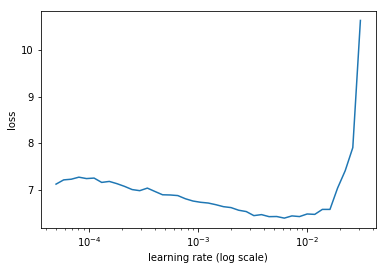

In [54]:
#import pdb; pdb.set_trace()
learn.lr_find()
learn.sched.plot()

In [61]:
?torch.index_select

In [87]:
# %debug

In [55]:
lr=3e-3

We can safely ignore the error 'Set changed size during iteration'  
http://forums.fast.ai/t/runtimeerror-set-changed-size-during-iteration/7565

In [57]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

# using try..except to ignore the error
# RuntimeError: Set changed size during iteration
#try:
#    learn.fit(lr, 1, cycle_len=10, use_clr=(20,10))
#except RuntimeError:
#    print('RuntimeError detected')

epoch      trn_loss   val_loss                            
    0      5.570353   5.410881  
    1      5.371669   4.897469                            
    2      5.023494   5.038763                            
    3      4.77653    4.759721                            
    4      4.551561   4.860833                            
    5      4.397697   4.742536                            
    6      4.088735   4.747053                            
    7      3.842484   4.598875                            
    8      3.65064    4.619178                            
    9      3.40026    4.525529                            
    10     3.144407   4.471087                            
    11     3.020039   4.393691                            



[array([4.39369])]

In [58]:
learn.save('initial')

In [59]:
learn.load('initial')

### Test

In [60]:
#x,y = next(iter(val_dl))
#probs = learn.model(V(x))
#preds = to_np(probs.max(2)[1])

for x, y in iter(val_dl):
    #print(x)
    for i in range(x.shape[1]):
        # fr -> en
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        
        probs = learn.model(V(x))
        preds = to_np(probs.max(2)[1])
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()
        
        # en -> fr
        #print(' '.join([en_itos[o] for o in x[:,i] if o != 1]))
        #print(' '.join([fr_itos[o] for o in y[:,i] if o != 1]))
        
        #probs = learn.model(V(x))
        #preds = to_np(probs.max(2)[1])
        #print(' '.join([fr_itos[o] for o in preds[:,i] if o!=1]))
        #print()

tom et mary acceptèrent de travailler ensemble sur le projet . _eos_
tom and mary agreed to work together on the project . _eos_
tom tom tom tom to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

je ne pense pas que tu aies fait ceci par toi-même . _eos_
i do n't think you did this by yourself . _eos_
i i have you you to to to . _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

peut-être que tom peut t' aider à trouver un travail . _eos_
perhaps tom can help you find a job . _eos_
you you a a to to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

j' aime prendre un petit déjeuner tardif . _eos_
i like to eat a late breakfast . _eos_
a a a to to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

pourquoi ne discutez - vous pas avec lui ? _eos_
why do n't you talk to him ? _eos_
do you you you a . _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

ne le ramassez pas . _eos_
do n't pick it up . _eos_
do the the the . .

## Bidir

When we added `bidirectional=True`, the Linear layer now needs number of hidden times 2 ( i.e. `nh*2` ) to reflect the fact that we have that second direction in our hidden state. Also in initHidden it’s now `self.nl*2`.

In [61]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        
        # Bidirectional encoder, adds a 2nd RNN in the opposite direction
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        
        # doubling the number of input neurones in the linear layer
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        
        self.drop_enc = nn.Dropout(0.05)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    # self.nl*2 because bidirectional is set to True
    # one hidden state vector for each RNN
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

Question: Why do you need to set a range to the loop? [1:20:58] Because when we start training, everything is random so `if (dec_inp==1).all(): break` will probably never be true. Later on, it will pretty much always break out eventually but basically we are going to go forever. It’s really important to remember when you are designing an architecture that when you start, the model knows nothing about anything. So you want to make sure if it’s going to do something at least it’s vaguely sensible.

In [62]:
#rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)

maxLenSentence = getMaxLenSentence(fr_ids)
rnn = Seq2SeqRNN_Bidir(fr_vecs, fr_itos, dim_fr_vec, en_vecs, en_itos, dim_en_vec, nh, maxLenSentence) # new implementation
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [63]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      5.863043   5.075959  
    1      6.044207   5.02854                             
    2      5.313451   4.963759                            
    3      4.857013   4.650207                            
    4      4.390748   4.654443                            
    5      4.26524    4.730703                            
    6      4.057316   4.539191                            
    7      3.739889   4.551198                            
    8      3.499628   4.310367                            
    9      3.266146   4.364414                            
    10     3.021368   4.386462                            
    11     2.739096   4.28379                             



[array([4.28379])]

In [64]:
learn.save('bidir')

### Test - Bidir

In [65]:
learn.load('bidir')
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

#print(x.shape)

#for i in range(180,190):
#for i in range(1):
#    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
#    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
#    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
#    print()
    
for x, y in iter(val_dl):
    #print(x)
    for i in range(x.shape[1]):
        # fr -> en
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        
        probs = learn.model(V(x))
        preds = to_np(probs.max(2)[1])
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()

tom et mary acceptèrent de travailler ensemble sur le projet . _eos_
tom and mary agreed to work together on the project . _eos_
tom tom too let with with . _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

je ne pense pas que tu aies fait ceci par toi-même . _eos_
i do n't think you did this by yourself . _eos_
i i do you to to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

peut-être que tom peut t' aider à trouver un travail . _eos_
perhaps tom can help you find a job . _eos_
please please please to you to to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

j' aime prendre un petit déjeuner tardif . _eos_
i like to eat a late breakfast . _eos_
i a to to to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

pourquoi ne discutez - vous pas avec lui ? _eos_
why do n't you talk to him ? _eos_
why do you you you _eos_ _eos_ _eos_ _eos_ _eo

## Teacher forcing

Now let’s talk about teacher forcing. When a model starts learning, it knows nothing about nothing. So when the model starts learning, it is not going to spit out “Er” at the first step, it is going to spit out some random meaningless word because it doesn’t know anything about German or about English or about the idea of language. And it is going to feed it to the next process as an input and be totally unhelpful. That means, early learning is going to be very difficult because it is feeding in an input that is stupid into a model that knows nothing and somehow it’s going to get better. So it is not asking too much eventually it gets there, but it’s definitely not as helpful as we can be. So what if instead of feeding in the thing I predicted just now, what if we instead we feed in the actual correct word was meant to be. We can’t do that at inference time because by definition we don’t know the correct word - it has to translate it. We can’t require the correct translation in order to do translation.  
![Seq2seq model][logo]
[logo]: https://cdn-images-1.medium.com/max/800/1*DU776SGr1rhYeU7ilIKX9w.png "Seq2seq model"

PyTorch make it easier to implement teacher forcing not like other static graphs frameworks like Tensorflow or Keras.  
Below, we're writing our own version of Stepper, instead of re-writting the whole training loop, this class will be responsible for decreasing pr_force after each epoch.

In [66]:
#class Seq2SeqStepper(Stepper):
#    def step(self, xs, y, epoch):
#        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
#        xtra = []
#        output = self.m(*xs, y)
#        if isinstance(output,tuple): output,*xtra = output
#        self.opt.zero_grad()
#        loss = raw_loss = self.crit(output, y)
#        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
#        loss.backward()
#        if self.clip:   # Gradient clipping
#            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
#        self.opt.step()
#        return raw_loss.data[0]

In [67]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        # the following line gradually decreases pr_force after each epoch (for the first 10 epochs)
        # after 10 epochs pr_force will be 0
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        return super().step(xs, y, epoch)

At the start of training, let’s set pr_force really high so that nearly always it gets the actual correct previous word and so it has a useful input. Then as we trained a bit more, let’s decrease pr_force so that by the end pr_force is zero and it has to learn properly which is fine because it is now actually feeding in sensible inputs most of the time anyway.

In [68]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break

            # pr_force: probability of forcing
            # if a random number if less than this probability, ...
            if (y is not None) and (random.random()<self.pr_force):
                
                # if it's longer than the target sentence, we stop
                if i>=len(y): break
                
                # ... we're going to replace the decoder input with the actual correct word
                dec_inp = y[i]
                
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [69]:
#rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)

maxLenSentence = getMaxLenSentence(fr_ids)
rnn = Seq2SeqRNN_TeacherForcing(fr_vecs, fr_itos, dim_fr_vec, en_vecs, en_itos, dim_en_vec, nh, maxLenSentence) # new implementation
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [70]:
# we have to pass in our custom stepper class
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                            
    0      5.592833   5.026546  
    1      5.415341   5.207315                            
    2      5.00852    4.857776                            
    3      4.723488   4.760334                            
    4      4.55963    4.600816                            
    5      4.318899   4.587016                            
    6      4.071668   4.615957                            
    7      3.780182   4.620639                            
    8      3.640652   4.609586                            
    9      3.489344   4.552939                            
    10     3.226872   4.538654                            
    11     3.059119   4.524024                            



[array([4.52402])]

In [71]:
learn.save('forcing')

In [72]:
for x, y in iter(val_dl):
    for i in range(x.shape[1]):
        # fr -> en
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        
        probs = learn.model(V(x))
        preds = to_np(probs.max(2)[1])
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()

tom et mary acceptèrent de travailler ensemble sur le projet . _eos_
tom and mary agreed to work together on the project . _eos_
tom is is a to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

je ne pense pas que tu aies fait ceci par toi-même . _eos_
i do n't think you did this by yourself . _eos_
i i have you to to to . _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

peut-être que tom peut t' aider à trouver un travail . _eos_
perhaps tom can help you find a job . _eos_
you a a a to to to _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

j' aime prendre un petit déjeuner tardif . _eos_
i like to eat a late breakfast . _eos_
look a a a with . _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

pourquoi ne discutez - vous pas avec lui ? _eos_
why do n't you talk to him ? _eos_
do do you take take . . _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _e

## Attentional model

The basic idea of attention is this — expecting the entirety of the sentence to be summarized into this single hidden vector is asking a lot. It has to know what was said, how it was said, and everything necessary to create the sentence in German. The idea of attention is basically maybe we are asking too much. Particularly because we could use this form of model (below) where we output every step of the loop to not just have a hidden state at the end but to have a hidden state after every single word. Why not try and use that information? It’s already there but so far we’ve just been throwing it away. Not only that but bi-directional, we got two vectors of state every step that we can use. How can we do this?  

![multiple output RNN][logo]
[logo]: https://cdn-images-1.medium.com/max/800/1*CX45skUFZZO6uHsR8IndzA.png "multiple output RNN"

Let’s say we are translating a word “liebte” right now [1:32:34]. Which of previous 5 pieces of state do we want? We clearly want “love” because it is the word. How about “zu”? We probably need “eat” and “to” and loved” to make sure we have gotten the tense right and know that I actually need this part of the verb and so forth. So depending on which bit we are translating, we would need one or more bits of these various hidden states. In fact, we probably want some weighting of them. In other words, for these five pieces of hidden state, we want a weighted average [1:33:47]. We want it weighted by something that can figure out which bits of the sentence is the most important right now. How do we figure out something like which bits of the sentence are important right now? We create a neural net and we train the neural net to figure it out. When do we train that neural net? End to end. So let’s now train two neural nets [1:34:18]. Well, we’ve already got a bunch — RNN encoder, RNN decoder, a couple of linear layers, what the heck, let’s add another neural net into the mix. This neural net is going to spit out a weight for every one of these states and we will take the weighted average at every step, and it’s just another set of parameters that we learn all at the same time. So that is called “attention”.

![attention mechanism][logo]
[logo]: https://cdn-images-1.medium.com/max/800/1*fkL30nxS54fKVmyC2jtMrw.png "attention mechanism"

With attention, most of the code is identical. The one major difference is this line: `Xa = (a.unsqueeze(2) * enc_out).sum(0)` . We are going to take a weighted average and the way we are going to do the weighted average is we create a little neural net which we are going to see here:  
```python
w2h = self.l2(h[-1])
u = F.tanh(w1e + w2h)
a = F.softmax(u @ self.V, 0)
```

In [73]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0]) # random tensor
def rand_p(*sz): return nn.Parameter(rand_t(*sz)) # wrapped up in a Parameter

# Parameter is just a PyTorch variable, it's like identical to a variable that it just tells PyTorch
# I want you to learn the weights for this.

In [74]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec*2, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        # instead of a linear layer, we can even just grab a random matrix if we don't care about bias
        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        
        # enc_out is the whole tensor of all of the encoder outputs
        # the RNN spits out 2 things:
        # list of states after each timestep, and the state at the last timestep
        # using Python we can return multiple objects unlike other languages
        enc_out, h = self.gru_enc(emb, h)
        
        # we used the state at the last time step to create the input state for our decoder
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res, attns = [], []
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            
            """
                We use softmax because the nice thing about softmax is that we want to ensure all
                of the weights that we are using add up to 1 and we also expect that one of those
                weights should probably be higher than the other ones [1:36:38]. Softmax gives us
                the guarantee that they add up to 1 and because it has e^ in it, it tends to
                encourage one of the weights to be higher than the other ones.
            """
            
            # creating a neural net
            
            # what's the information we use to decide what word / words we should focus on next
            # the only information we have to go on is what the decoder's hidden state is now
            
            # h[-1] is the last layer's hidden state which is the current hidden state of the decoder
            # we stick it into a linear layer
            w2h = self.l2(h[-1])
            
            # then stick it into a non-linear activation
            u = F.tanh(w1e + w2h)
            
            # applying softmax to ensure that all of the weights add up to 1
            # and we also kind of expect that one of those weights should
            # probably be quite a bit higher than the other ones
            
            # then we're going to do a matrix multiplication
            # (In Python, A @ B is the matrix product, A * B the element-wise product)
            # stick it to a softmax
            # self.V doesn't have a bias, so, u @ self.V is just a matrix multiplication
            a = F.softmax(u @ self.V, 0)
            
            # linear layer --> nonlinear activation --> matrix multiply = neural net with one hidden layer
            
            attns.append(a)
            
            # and we're going to use the softmax output to weight the encoder's outputs
            # instead of using only the last encoder output, we're using all of them weighted by the neural net
            # we created (attention weights)
            Xa = (a.unsqueeze(2) * enc_out).sum(0) # weighted average
            
            # the idea is not to use the last hidden state h only but all of the encoder states enc_out
            # and multiply them by the output of the neural net (which predicts the attention weights)
            
            # given that the things in this little neural net are learnable weights, hopefully, it's
            # going to learn to weight those encoder outputs, those encoder hidden states by something useful
            
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            
            # Here, we have teacher forcing, but it's not bi-directional
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res, torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

Remember that the loss values are logs, so `e^` to these values is quite a significant change

In [75]:
#rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)

maxLenSentence = getMaxLenSentence(en_ids)
rnn = Seq2SeqAttnRNN(fr_vecs, fr_itos, dim_fr_vec, en_vecs, en_itos, dim_en_vec, nh, maxLenSentence) # new implementation
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [76]:
#lr=2e-3
lr=5e-2

In [77]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                            
    0      19.528716  15.789285 
    1      27.617228  19.811899                           
    2      25.820983  17.501958                           
    3      23.395736  15.900296                           
    4      21.87846   17.650807                           
    5      18.729571  15.140794                           
    6      26.027504  17.623428                           
    7      18.98835   13.993108                           
    8      15.549684  14.099075                           
    9      14.069646  13.516583                           
    10     12.506038  13.08138                            
    11     11.151686  12.206781                           
    12     10.347207  11.840073                           
    13     9.598738   10.900506                           
    14     8.896447   10.704287                           



[array([10.70429])]

In [78]:
learn.save('attn')

In [79]:
learn.load('attn')

### Test

In [80]:
x,y = next(iter(val_dl))
probs, attns = learn.model(V(x), ret_attn=True)
preds = to_np(probs.max(2)[1])

In [81]:
x.shape[1]

1

In [82]:
for x,y in iter(val_dl):
    #print(x)
    for i in range(x.shape[1]):
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()

tom et mary acceptèrent de travailler ensemble sur le projet . _eos_
tom and mary agreed to work together on the project . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

je ne pense pas que tu aies fait ceci par toi-même . _eos_
i do n't think you did this by yourself . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

peut-être que tom peut t' aider à trouver un travail . _eos_
perhaps tom can help you find a job . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

j' aime prendre un petit déjeuner tardif . _eos_
i like to eat a late breakfast . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

pourquoi ne discutez - vous pas avec lui ? _eos_
why do n't you talk to him ? _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eo

### Visualizing attention

In [83]:
#attn = to_np(attns[...,180])
attn = to_np(attns)

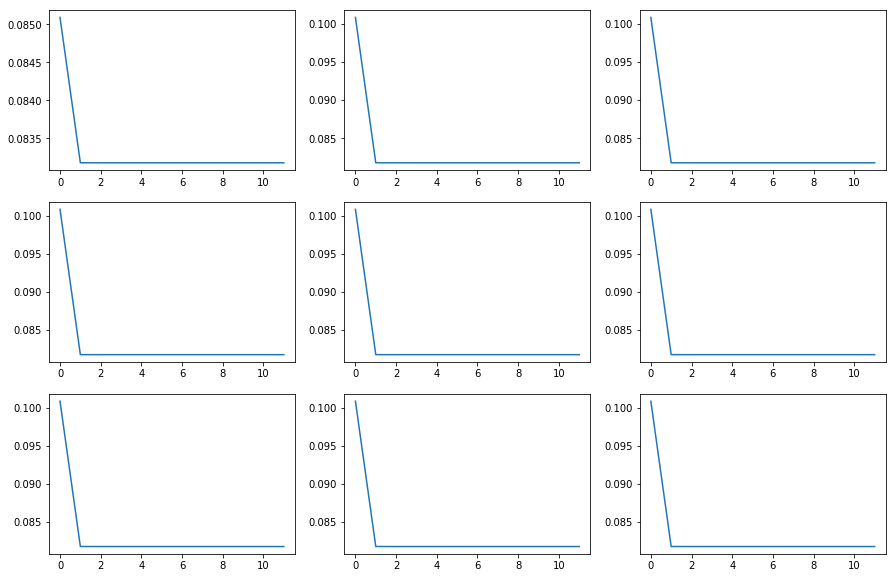

In [84]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

In [85]:
#for i in range(180,190):
for i in range(x.shape[1]):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

attention aux imitations . _eos_
beware of imitations . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_



Not bad. It’s still not perfect but quite a few of them are correct and again considering that we are asking it to learn about the very idea of language for two different languages and how to translate them between the two, and grammar, and vocabulary, and we only have 50,000 sentences and a lot of the words only appear once, I would say this is actually pretty amazing.

End-to-end learning means you throw in everything you can into one loss function and the gradients of all the different parameters point in a direction that says “hey, you know if you had put more weight over there, it would have been better.”

## All

In [89]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [90]:
#rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
maxLenSentence = getMaxLenSentence(en_ids)
rnn = Seq2SeqRNN_All(fr_vecs, fr_itos, dim_fr_vec, en_vecs, en_itos, dim_en_vec, nh, maxLenSentence) # new implementation
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [92]:
#learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)
learn.fit(lr, 1, cycle_len=50, use_clr=(20,10), stepper=Seq2SeqStepper)

  1%|          | 1/86 [00:00<00:45,  1.85it/s, loss=31.1] 


Exception in thread Thread-62:
Traceback (most recent call last):
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      20.747583  23.754635 
    1      21.734942  26.819055                           
    2      41.705909  47.69762                            
    3      40.685617  38.07177                            
    4      42.198275  42.670547                           
    5      43.92175   46.869793                           
    6      44.144599  40.665845                           
    7      42.901063  41.291865                           
    8      43.685156  45.55401                            
    9      42.153237  42.806808                           
    10     37.173446  41.450775                           
    11     37.949422  48.568005                           
    12     37.752102  43.290563                           
    13     36.914385  43.623336                           
    14     33.63517   46.592167                           
    15     35.546144  43.953029                           
    16     32.720374  3

[array([30.77827])]

### Test

In [93]:
for x,y in iter(val_dl):
    #for i in range(180,190):
    for i in range(x.shape[1]):
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        
        probs = learn.model(V(x))
        preds = to_np(probs.max(2)[1])
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()

tom et mary acceptèrent de travailler ensemble sur le projet . _eos_
tom and mary agreed to work together on the project . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

je ne pense pas que tu aies fait ceci par toi-même . _eos_
i do n't think you did this by yourself . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

peut-être que tom peut t' aider à trouver un travail . _eos_
perhaps tom can help you find a job . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

j' aime prendre un petit déjeuner tardif . _eos_
i like to eat a late breakfast . _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_

pourquoi ne discutez - vous pas avec lui ? _eos_
why do n't you talk to him ? _eos_
_eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eos_ _eo